# Recognizing hand-written digits

## Introduction

This notebook adapts the existing example of applying support vector classification from scikit-learn ([https://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html#sphx-glr-auto-examples-classification-plot-digits-classification-py](https://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html#sphx-glr-auto-examples-classification-plot-digits-classification-py)) to PyRCN to demonstrate, how PyRCN can be used to classify hand-written digits.

The tutorial is based on numpy, scikit-learn and PyRCN. We are using the ESNRegressor, because we further process the outputs of the ESN. Note that the same can also be done using the ESNClassifier. Then, during prediction, we simply call "predict_proba".

This tutorial requires the Python modules numpy, scikit-learn, matplotlib and pyrcn.

In [1]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import clone
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, ConfusionMatrixDisplay

from matplotlib import pyplot as plt
plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
%matplotlib inline

from pyrcn.echo_state_network import ESNRegressor

## Load the dataset

The dataset is already part of scikit-learn and consists of 1797 8x8 images. We are using the dataloader from scikit-learn.

In [2]:
digits = load_digits()
data = digits.images
print("Number of digits: {0}".format(len(data)))
print("Shape of digits {0}".format(data[0].shape))

Number of digits: 1797
Shape of digits (8, 8)


## Split dataset in training and test

We use the OneHotEncoder to transform the target output into one-hot encoded values. 

Afterwards, we split the dataset into training and test sets. We train the ESN using 50% of the digits and test it using the remaining images. 

We treat each image as a sequence of 8 feature vectors with 8 dimensions.

In [3]:
# Split data into train and test subsets
enc = OneHotEncoder(sparse=False)
y = enc.fit_transform(X=digits.target.reshape(-1, 1))
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.5, shuffle=False)
print("Number of digits in training set: {0}".format(len(X_train)))
print("Shape of digits in training set: {0}".format(X_train[0].shape))
print("Shape of output in training set: {0}".format(y_train[0].shape))
print("Number of digits in test set: {0}".format(len(X_test)))
print("Shape of digits in test set: {0}".format(X_test[0].shape))
print("Shape of output in test set: {0}".format(y_test[0].shape))

Number of digits in training set: 898
Shape of digits in training set: (8, 8)
Shape of output in training set: (10,)
Number of digits in test set: 899
Shape of digits in test set: (8, 8)
Shape of output in test set: (10,)


## Set up a basic ESN

To develop an ESN model for digit recognition, we need to tune several hyper-parameters, e.g., input_scaling, spectral_radius, bias_scaling and leaky integration.

We follow the way proposed in the introductory paper of PyRCN to optimize hyper-parameters sequentially.

We start to jointly optimize input_scaling and spectral_radius and therefore deactivate bias connections and leaky integration. This is our base_reg.

We define the search space for input_scaling and spectral_radius. This is done using best practice and background information from the literature: The spectral radius, the largest absolute eigenvalue of the reservoir matrix, is often smaller than 1. Thus, we can search in a space between 0.0 (e.g. no recurrent connections) and 1.0 (maximum recurrent connections). It is usually recommended to tune the input_scaling factor between 0.1 and 1.0. However, as this is strongly task-dependent, we decided to slightly increase the search space.

In [4]:
base_reg = ESNRegressor(k_in = 5, input_scaling = 0.1, spectral_radius = 0.0, bias = 0.0, leakage = 1.0, reservoir_size = 50, 
                   k_res = 5, reservoir_activation = 'tanh', teacher_scaling = 1.0, teacher_shift = 0.0, 
                   bi_directional = False, solver = 'ridge', beta = 5e-3, random_state = 1)

grid = {'input_scaling': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5], 
        'spectral_radius': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
       }

## Optimize input_scaling and spectral_radius

We use the ParameterGrid from scikit-learn, which converts the grid parameters defined before into a list of dictionaries for each parameter combination. 

We loop over each entry of the Parameter Grid, set the parameters in reg and fit our model on the training data. Afterwards, we report the MSE on the training and test set.  

    The lowest training MSE: 0.0725333549527569; parameter combination: {'input_scaling': 0.1, 'spectral_radius': 1.0}
    The lowest test MSE: 0.0755270784848419; parameter combination: {'input_scaling': 0.1, 'spectral_radius': 0.9}

We use the best parameter combination from the training set, because we do not want to overfit on the test set.

As we can see in the python call, we have modified the training procedure: We use "partial_fit" in order to present the ESN all sequences independently from each other. The function "partial_fit" is part of the scikit-learn API. We have added one optional argument "update_output_weights". By default, it is True and thus, after feeding one sequence through the ESN, output weights are computed.

However, as this is computationally expensive, we can deactivate computing output weights after each sequence by setting "update_output_weights" to False. Now, we simply collect sufficient statistics for the later linear regression. To finish the training process, we call finalize() after passing all sequences through the ESN.

In [5]:
for params in ParameterGrid(grid):
    print(params)
    reg = clone(base_reg)
    reg.set_params(**params)
    for X, y in zip(X_train, y_train):
        y = np.repeat(np.atleast_2d(y), repeats=8, axis=0)
        reg.partial_fit(X=X, y=y, update_output_weights=False)
    reg.finalize()
    err_train = []
    for X, y in zip(X_train, y_train):
        y = np.repeat(np.atleast_2d(y), repeats=8, axis=0)
        y_pred = reg.predict(X=X, keep_reservoir_state=False)
        err_train.append(mean_squared_error(y, y_pred))
    err_test = []
    for X, y in zip(X_test, y_test):
        y = np.repeat(np.atleast_2d(y), repeats=8, axis=0)
        y_pred = reg.predict(X=X, keep_reservoir_state=False)
        err_test.append(mean_squared_error(y, y_pred))
    print('{0}\t{1}'.format(np.mean(err_train), np.mean(err_test)))
        
    

{'input_scaling': 0.1, 'spectral_radius': 0.0}
0.0773829101563099	0.08003260710824718
{'input_scaling': 0.1, 'spectral_radius': 0.1}
0.0757476590395697	0.07847961941697255
{'input_scaling': 0.1, 'spectral_radius': 0.2}
0.074926068030771	0.07760217958084958
{'input_scaling': 0.1, 'spectral_radius': 0.3}
0.0743663189555471	0.07690941765539568
{'input_scaling': 0.1, 'spectral_radius': 0.4}
0.07395223791976122	0.07640996878636475
{'input_scaling': 0.1, 'spectral_radius': 0.5}
0.07362128843354852	0.07607774323920946
{'input_scaling': 0.1, 'spectral_radius': 0.6}
0.07333537510510157	0.07585461014840986
{'input_scaling': 0.1, 'spectral_radius': 0.7}
0.07307768680255937	0.07569622788866028
{'input_scaling': 0.1, 'spectral_radius': 0.8}
0.07284674495742895	0.07558358532038291
{'input_scaling': 0.1, 'spectral_radius': 0.9}
0.07265734766229882	0.07552707848484196
{'input_scaling': 0.1, 'spectral_radius': 1.0}
0.07253335495275691	0.07555869166615845
{'input_scaling': 0.2, 'spectral_radius': 0.0}
0

0.07939391808326889	0.08216415680718828
{'input_scaling': 0.9, 'spectral_radius': 0.7}
0.0793412087171875	0.08207181973929051
{'input_scaling': 0.9, 'spectral_radius': 0.8}
0.07929612788919752	0.08198206563640688
{'input_scaling': 0.9, 'spectral_radius': 0.9}
0.07925526718963623	0.0818953680376751
{'input_scaling': 0.9, 'spectral_radius': 1.0}
0.07921576551410832	0.08181180664682297
{'input_scaling': 1.0, 'spectral_radius': 0.0}
0.07988049190179071	0.08246443081091535
{'input_scaling': 1.0, 'spectral_radius': 0.1}
0.07987480901299869	0.08253700637324282
{'input_scaling': 1.0, 'spectral_radius': 0.2}
0.0798150895126336	0.08254629859419431
{'input_scaling': 1.0, 'spectral_radius': 0.3}
0.07973112882052644	0.0825074834781121
{'input_scaling': 1.0, 'spectral_radius': 0.4}
0.07964707441068165	0.08244293790908457
{'input_scaling': 1.0, 'spectral_radius': 0.5}
0.07957400048910553	0.08236778924359665
{'input_scaling': 1.0, 'spectral_radius': 0.6}
0.07951420515042952	0.08228955736305435
{'input

## Update parameter of the basic ESN

After optimizing input_scaling and spectral_radius, we update our basic ESN with the identified values for input_scaling and spectral_radius. 

For the next optimization step, we jointly optimize bias and leakage.

We define the search space for bias and leakage. This is again done using best practice and background information from the literature: The bias often lies in a similar value range as the input scaling. Thus we use exactly the same search space as before. The leakage, the parameter of the leaky integration is defined in (0.0, 1.0]. Thus, we tune the leakage between 0.1 and 1.0.

In [6]:
base_reg = ESNRegressor(k_in = 5, input_scaling = 0.1, spectral_radius = 1.0, bias = 0.0, leakage = 1.0, reservoir_size = 50, 
                   k_res = 5, reservoir_activation = 'tanh', teacher_scaling = 1.0, teacher_shift = 0.0, 
                   bi_directional = False, solver = 'ridge', beta = 5e-3, random_state = 1)

grid = {'bias': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5], 
        'leakage': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
       }

## Optimize bias and leakage

The optimization workflow is exactly the same as before: We define a ParameterGrid, loop over each entry, set the parameters in reg and fit our model on the training data. Afterwards, we report the MSE on the training and test set.  

    The lowest training MSE: 0.0564864449264251; parameter combination: {'bias': 0.8, 'leakage': 0.2}
    The lowest test MSE: 0.0626353459066059; parameter combination: {'bias': 0.1, 'leakage': 0.2}

We use the best parameter combination from the training set, because we do not want to overfit on the test set.

Note that the bias differs a lot between training and test set. A reason can be that the training set does not completely represent the test set. This should actually be investigated by comparing several train_test_splits, maybe even with other sample sizes.

In [7]:
for params in ParameterGrid(grid):
    print(params)
    reg = clone(base_reg)
    reg.set_params(**params)
    for X, y in zip(X_train, y_train):
        y = np.repeat(np.atleast_2d(y), repeats=8, axis=0)
        reg.partial_fit(X=X, y=y, update_output_weights=False)
    reg.finalize()
    err_train = []
    for X, y in zip(X_train, y_train):
        y = np.repeat(np.atleast_2d(y), repeats=8, axis=0)
        y_pred = reg.predict(X=X, keep_reservoir_state=False)
        err_train.append(mean_squared_error(y, y_pred))
    err_test = []
    for X, y in zip(X_test, y_test):
        y = np.repeat(np.atleast_2d(y), repeats=8, axis=0)
        y_pred = reg.predict(X=X, keep_reservoir_state=False)
        err_test.append(mean_squared_error(y, y_pred))
    print('{0}\t{1}'.format(np.mean(err_train), np.mean(err_test)))
        
    

{'bias': 0.0, 'leakage': 0.1}
0.058054761660325416	0.06367895337595333
{'bias': 0.0, 'leakage': 0.2}
0.05729855209551581	0.06284150224246933
{'bias': 0.0, 'leakage': 0.3}
0.058345618099881695	0.06389666538094538
{'bias': 0.0, 'leakage': 0.4}
0.06005526632464609	0.06552873765617934
{'bias': 0.0, 'leakage': 0.5}
0.06202717502812057	0.06728284270757032
{'bias': 0.0, 'leakage': 0.6}
0.06413384409143663	0.0690457392885266
{'bias': 0.0, 'leakage': 0.7}
0.06630860134648743	0.07078346954254039
{'bias': 0.0, 'leakage': 0.8}
0.06847078812230814	0.07244694815921442
{'bias': 0.0, 'leakage': 0.9}
0.07055500217493954	0.0740229934022282
{'bias': 0.0, 'leakage': 1.0}
0.07253335495275694	0.07555869166615818
{'bias': 0.1, 'leakage': 0.1}
0.05781333940379996	0.06340331130002994
{'bias': 0.1, 'leakage': 0.2}
0.05721123744140935	0.06263534590660592
{'bias': 0.1, 'leakage': 0.3}
0.05833984084700798	0.06381564815450902
{'bias': 0.1, 'leakage': 0.4}
0.06009663922261382	0.06557403249841647
{'bias': 0.1, 'leaka

0.06866973043143539	0.07161094397923141
{'bias': 1.1, 'leakage': 0.9}
0.07047008846986624	0.07307024318156981
{'bias': 1.1, 'leakage': 1.0}
0.07224607717067744	0.07466530392233836
{'bias': 1.2, 'leakage': 0.1}
0.05740028410636806	0.06302004566556979
{'bias': 1.2, 'leakage': 0.2}
0.05693672146900798	0.06292913174398303
{'bias': 1.2, 'leakage': 0.3}
0.05831446809774137	0.06403946145352493
{'bias': 1.2, 'leakage': 0.4}
0.060357439660011065	0.06557064612580675
{'bias': 1.2, 'leakage': 0.5}
0.0626462362591805	0.06727318288955142
{'bias': 1.2, 'leakage': 0.6}
0.06487361965874967	0.0688971185960274
{'bias': 1.2, 'leakage': 0.7}
0.06690881704522979	0.07034267238037763
{'bias': 1.2, 'leakage': 0.8}
0.0687802137953625	0.07171734810093323
{'bias': 1.2, 'leakage': 0.9}
0.07055511737289374	0.07317671858446455
{'bias': 1.2, 'leakage': 1.0}
0.07229335839031054	0.0747636414422639
{'bias': 1.3, 'leakage': 0.1}
0.057510828836972026	0.06305612592494392
{'bias': 1.3, 'leakage': 0.2}
0.05708102945603819	0.

## Update parameter of the basic ESN

After optimizing bias and leakage, we update our basic ESN with the identified values for bias and leakage. 

Finally, we would quickly like to see whether the regularization parameter beta lies in the correct range.

Typically, it is rather difficult to find a proper search range. Here, we use a very rough logarithmic search space.

In [8]:
base_reg = ESNRegressor(k_in = 5, input_scaling = 0.1, spectral_radius = 1.0, bias = 0.8, leakage = 0.1, reservoir_size = 50, 
                   k_res = 5, reservoir_activation = 'tanh', teacher_scaling = 1.0, teacher_shift = 0.0, 
                   bi_directional = False, solver = 'ridge', beta = 5e-3, random_state = 1)

grid = {'beta': [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 5e-1, 1e0], 
       }

## Optimize beta

The optimization workflow is exactly the same as before: We define a ParameterGrid, loop over each entry, set the parameters in reg and fit our model on the training data. Afterwards, we report the MSE on the training and test set.  

    The lowest training MSE: 0.055284106204655556; parameter combination: {'beta': 0.0005}
    The lowest test MSE: 0.06266313201574032; parameter combination: {'beta': 0.001}

We use the best parameter combination from the test set, because the regularization is responsible to prevent overfitting on the training set. In a running system, of course, we should determine the regularization on a separate validation set.

In [9]:
for params in ParameterGrid(grid):
    print(params)
    reg = clone(base_reg)
    reg.set_params(**params)
    for X, y in zip(X_train, y_train):
        y = np.repeat(np.atleast_2d(y), repeats=8, axis=0)
        reg.partial_fit(X=X, y=y, update_output_weights=False)
    reg.finalize()
    err_train = []
    for X, y in zip(X_train, y_train):
        y = np.repeat(np.atleast_2d(y), repeats=8, axis=0)
        y_pred = reg.predict(X=X, keep_reservoir_state=False)
        err_train.append(mean_squared_error(y, y_pred))
    err_test = []
    for X, y in zip(X_test, y_test):
        y = np.repeat(np.atleast_2d(y), repeats=8, axis=0)
        y_pred = reg.predict(X=X, keep_reservoir_state=False)
        err_test.append(mean_squared_error(y, y_pred))
    print('{0}\t{1}'.format(np.mean(err_train), np.mean(err_test)))
        
    

{'beta': 1e-05}
0.055282423510929796	0.0628164221681407
{'beta': 5e-05}
0.05528242369095944	0.0628159463620178
{'beta': 0.0001}
0.05528242638951189	0.0628144636044127
{'beta': 0.0005}
0.055284106204655764	0.06277013690612206
{'beta': 0.001}
0.05530475421070296	0.06266313201574725
{'beta': 0.005}
0.05693034379667328	0.06287679296183171
{'beta': 0.01}
0.05968922697424045	0.06451318664506327
{'beta': 0.05}
0.07098384041686397	0.07344906330355215
{'beta': 0.1}
0.07587555905479525	0.07770309775709949
{'beta': 0.5}
0.08595590217539589	0.08643564946389475
{'beta': 1.0}
0.08964202550783872	0.0898204860162833


## Update parameter of the basic ESN

After optimizing beta, we update our basic ESN with the identified value for beta.

Note that we have used almost the ideal value already in the beginning. Thus, the impact is rather small.

Next, we want to measure the classification accuracy. To do that, we compare several reservoir sizes as well as unidirectional and bidirectional architectures.

Because this is a rather small dataset, we can use rather small reservoir sizes and increase it up to 5000 neurons.

In [10]:
base_reg = ESNRegressor(k_in = 5, input_scaling = 0.1, spectral_radius = 1.0, bias = 0.8, leakage = 0.1, reservoir_size = 50, 
                   k_res = 5, reservoir_activation = 'tanh', teacher_scaling = 1.0, teacher_shift = 0.0, 
                   bi_directional = False, solver = 'ridge', beta = 0.0005, random_state = 1)

grid = {'reservoir_size': [50, 100, 200, 400, 500, 800, 1000, 2000, 4000, 5000], 
        'bi_directional': [False, True]
       }

## Test the ESN

In the test case, we use a simple variant of sequence classification:

The ESN computes the output for each sequence. We integrate the outputs over time and find the highest integrated output index. This is the label of the sequence.

We store all ground truth labels and the predicted labels for training and test. Then, we use the scikit-learn's classification_report and plot a confusion matrix in order to show the classification performance.

As can be seen, the reservoir size as a very strong impact on the classification result.

{'bi_directional': False, 'reservoir_size': 50}
Classification training report for estimator ESNRegressor(beta=0.0005, bi_directional=False, bias=0.8, ext_bias=0,
             input_scaling=0.1, k_in=5, k_res=5, leakage=0.1, random_state=1,
             reservoir_activation='tanh', reservoir_size=50, solver='ridge',
             spectral_radius=1.0, teacher_scaling=1.0, teacher_shift=0.0,
             wash_out=0):
              precision    recall  f1-score   support

           0       0.90      1.00      0.95        90
           1       0.83      0.90      0.86        91
           2       0.78      0.74      0.76        91
           3       0.86      0.74      0.80        92
           4       0.91      0.91      0.91        89
           5       0.89      0.96      0.92        91
           6       0.84      0.93      0.88        90
           7       0.83      0.90      0.86        90
           8       0.85      0.74      0.80        86
           9       0.88      0.74      0.

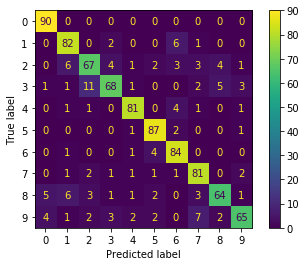

Classification test report for estimator ESNRegressor(beta=0.0005, bi_directional=False, bias=0.8, ext_bias=0,
             input_scaling=0.1, k_in=5, k_res=5, leakage=0.1, random_state=1,
             reservoir_activation='tanh', reservoir_size=50, solver='ridge',
             spectral_radius=1.0, teacher_scaling=1.0, teacher_shift=0.0,
             wash_out=0):
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        88
           1       0.80      0.73      0.76        91
           2       0.70      0.57      0.63        86
           3       0.72      0.73      0.72        91
           4       0.84      0.90      0.87        92
           5       0.68      0.87      0.76        91
           6       0.77      0.95      0.85        91
           7       0.79      0.80      0.79        89
           8       0.77      0.55      0.64        88
           9       0.80      0.76      0.78        92

    accuracy                          

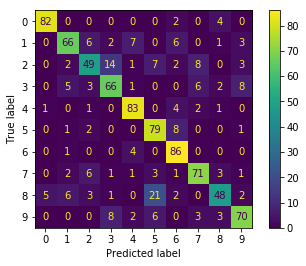

{'bi_directional': False, 'reservoir_size': 100}
Classification training report for estimator ESNRegressor(beta=0.0005, bi_directional=False, bias=0.8, ext_bias=0,
             input_scaling=0.1, k_in=5, k_res=5, leakage=0.1, random_state=1,
             reservoir_activation='tanh', reservoir_size=100, solver='ridge',
             spectral_radius=1.0, teacher_scaling=1.0, teacher_shift=0.0,
             wash_out=0):
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        90
           1       0.82      0.98      0.89        91
           2       0.89      0.78      0.83        91
           3       0.92      0.86      0.89        92
           4       0.96      0.91      0.94        89
           5       0.97      0.98      0.97        91
           6       0.93      0.96      0.95        90
           7       0.88      0.92      0.90        90
           8       0.91      0.86      0.89        86
           9       0.91      0.89      

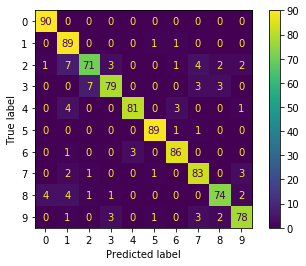

Classification test report for estimator ESNRegressor(beta=0.0005, bi_directional=False, bias=0.8, ext_bias=0,
             input_scaling=0.1, k_in=5, k_res=5, leakage=0.1, random_state=1,
             reservoir_activation='tanh', reservoir_size=100, solver='ridge',
             spectral_radius=1.0, teacher_scaling=1.0, teacher_shift=0.0,
             wash_out=0):
              precision    recall  f1-score   support

           0       0.93      0.95      0.94        88
           1       0.89      0.79      0.84        91
           2       0.80      0.73      0.76        86
           3       0.82      0.79      0.80        91
           4       0.90      0.95      0.92        92
           5       0.80      0.85      0.82        91
           6       0.83      0.96      0.89        91
           7       0.85      0.80      0.82        89
           8       0.81      0.75      0.78        88
           9       0.76      0.80      0.78        92

    accuracy                         

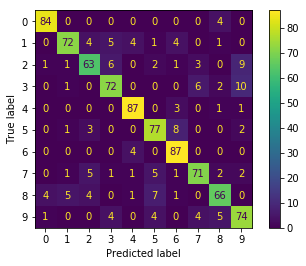

{'bi_directional': False, 'reservoir_size': 200}
Classification training report for estimator ESNRegressor(beta=0.0005, bi_directional=False, bias=0.8, ext_bias=0,
             input_scaling=0.1, k_in=5, k_res=5, leakage=0.1, random_state=1,
             reservoir_activation='tanh', reservoir_size=200, solver='ridge',
             spectral_radius=1.0, teacher_scaling=1.0, teacher_shift=0.0,
             wash_out=0):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        90
           1       0.88      0.99      0.93        91
           2       0.94      0.90      0.92        91
           3       0.98      0.96      0.97        92
           4       0.99      0.96      0.97        89
           5       0.99      0.99      0.99        91
           6       0.97      0.98      0.97        90
           7       0.93      1.00      0.96        90
           8       0.95      0.86      0.90        86
           9       0.98      0.94      

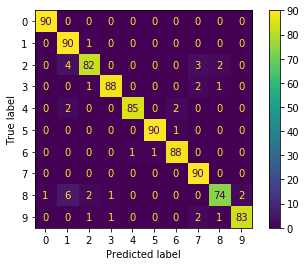

Classification test report for estimator ESNRegressor(beta=0.0005, bi_directional=False, bias=0.8, ext_bias=0,
             input_scaling=0.1, k_in=5, k_res=5, leakage=0.1, random_state=1,
             reservoir_activation='tanh', reservoir_size=200, solver='ridge',
             spectral_radius=1.0, teacher_scaling=1.0, teacher_shift=0.0,
             wash_out=0):
              precision    recall  f1-score   support

           0       0.98      0.97      0.97        88
           1       0.91      0.91      0.91        91
           2       0.79      0.76      0.77        86
           3       0.91      0.89      0.90        91
           4       0.87      0.96      0.91        92
           5       0.89      0.89      0.89        91
           6       0.91      0.95      0.92        91
           7       0.84      0.85      0.84        89
           8       0.87      0.78      0.83        88
           9       0.86      0.87      0.86        92

    accuracy                         

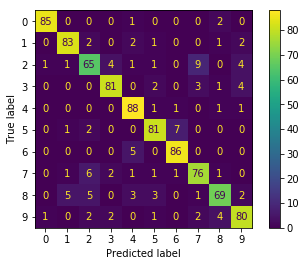

{'bi_directional': False, 'reservoir_size': 400}
Classification training report for estimator ESNRegressor(beta=0.0005, bi_directional=False, bias=0.8, ext_bias=0,
             input_scaling=0.1, k_in=5, k_res=5, leakage=0.1, random_state=1,
             reservoir_activation='tanh', reservoir_size=400, solver='ridge',
             spectral_radius=1.0, teacher_scaling=1.0, teacher_shift=0.0,
             wash_out=0):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        90
           1       0.97      1.00      0.98        91
           2       0.99      0.96      0.97        91
           3       0.97      1.00      0.98        92
           4       1.00      0.99      0.99        89
           5       0.99      1.00      0.99        91
           6       0.99      1.00      0.99        90
           7       0.98      1.00      0.99        90
           8       1.00      0.97      0.98        86
           9       1.00      0.97      

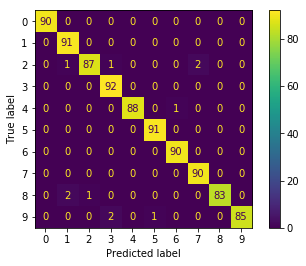

Classification test report for estimator ESNRegressor(beta=0.0005, bi_directional=False, bias=0.8, ext_bias=0,
             input_scaling=0.1, k_in=5, k_res=5, leakage=0.1, random_state=1,
             reservoir_activation='tanh', reservoir_size=400, solver='ridge',
             spectral_radius=1.0, teacher_scaling=1.0, teacher_shift=0.0,
             wash_out=0):
              precision    recall  f1-score   support

           0       0.99      0.97      0.98        88
           1       0.96      0.95      0.95        91
           2       0.81      0.78      0.79        86
           3       0.88      0.89      0.89        91
           4       0.92      0.97      0.94        92
           5       0.91      0.90      0.91        91
           6       0.90      0.95      0.92        91
           7       0.84      0.88      0.86        89
           8       0.87      0.83      0.85        88
           9       0.89      0.85      0.87        92

    accuracy                         

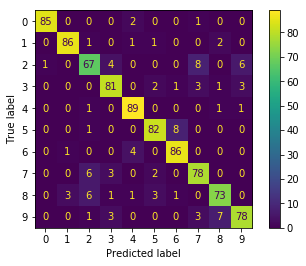

{'bi_directional': False, 'reservoir_size': 500}
Classification training report for estimator ESNRegressor(beta=0.0005, bi_directional=False, bias=0.8, ext_bias=0,
             input_scaling=0.1, k_in=5, k_res=5, leakage=0.1, random_state=1,
             reservoir_activation='tanh', reservoir_size=500, solver='ridge',
             spectral_radius=1.0, teacher_scaling=1.0, teacher_shift=0.0,
             wash_out=0):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        90
           1       0.98      1.00      0.99        91
           2       0.99      0.96      0.97        91
           3       0.99      1.00      0.99        92
           4       1.00      0.99      0.99        89
           5       1.00      1.00      1.00        91
           6       0.99      1.00      0.99        90
           7       0.98      1.00      0.99        90
           8       1.00      0.99      0.99        86
           9       1.00      0.98      

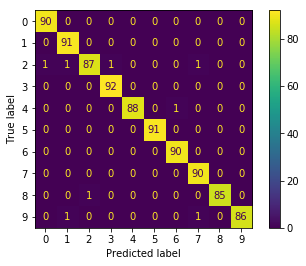

Classification test report for estimator ESNRegressor(beta=0.0005, bi_directional=False, bias=0.8, ext_bias=0,
             input_scaling=0.1, k_in=5, k_res=5, leakage=0.1, random_state=1,
             reservoir_activation='tanh', reservoir_size=500, solver='ridge',
             spectral_radius=1.0, teacher_scaling=1.0, teacher_shift=0.0,
             wash_out=0):
              precision    recall  f1-score   support

           0       0.99      0.97      0.98        88
           1       0.98      0.95      0.96        91
           2       0.82      0.83      0.82        86
           3       0.87      0.88      0.87        91
           4       0.91      0.97      0.94        92
           5       0.87      0.91      0.89        91
           6       0.94      0.93      0.94        91
           7       0.87      0.82      0.84        89
           8       0.84      0.86      0.85        88
           9       0.90      0.87      0.88        92

    accuracy                         

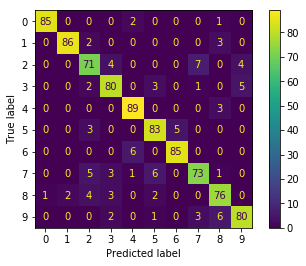

{'bi_directional': False, 'reservoir_size': 800}
Classification training report for estimator ESNRegressor(beta=0.0005, bi_directional=False, bias=0.8, ext_bias=0,
             input_scaling=0.1, k_in=5, k_res=5, leakage=0.1, random_state=1,
             reservoir_activation='tanh', reservoir_size=800, solver='ridge',
             spectral_radius=1.0, teacher_scaling=1.0, teacher_shift=0.0,
             wash_out=0):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        90
           1       1.00      1.00      1.00        91
           2       1.00      0.99      0.99        91
           3       0.99      1.00      0.99        92
           4       1.00      0.99      0.99        89
           5       1.00      1.00      1.00        91
           6       0.99      1.00      0.99        90
           7       1.00      1.00      1.00        90
           8       1.00      1.00      1.00        86
           9       1.00      1.00      

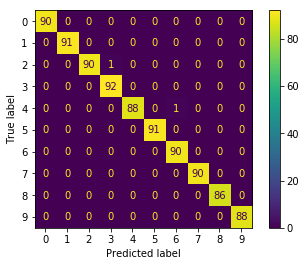

Classification test report for estimator ESNRegressor(beta=0.0005, bi_directional=False, bias=0.8, ext_bias=0,
             input_scaling=0.1, k_in=5, k_res=5, leakage=0.1, random_state=1,
             reservoir_activation='tanh', reservoir_size=800, solver='ridge',
             spectral_radius=1.0, teacher_scaling=1.0, teacher_shift=0.0,
             wash_out=0):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99        88
           1       0.97      0.93      0.95        91
           2       0.80      0.80      0.80        86
           3       0.83      0.89      0.86        91
           4       0.93      0.97      0.95        92
           5       0.90      0.88      0.89        91
           6       0.92      0.96      0.94        91
           7       0.79      0.81      0.80        89
           8       0.87      0.83      0.85        88
           9       0.92      0.84      0.88        92

    accuracy                         

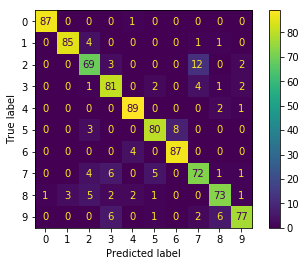

{'bi_directional': False, 'reservoir_size': 1000}
Classification training report for estimator ESNRegressor(beta=0.0005, bi_directional=False, bias=0.8, ext_bias=0,
             input_scaling=0.1, k_in=5, k_res=5, leakage=0.1, random_state=1,
             reservoir_activation='tanh', reservoir_size=1000, solver='ridge',
             spectral_radius=1.0, teacher_scaling=1.0, teacher_shift=0.0,
             wash_out=0):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        90
           1       1.00      1.00      1.00        91
           2       1.00      0.99      0.99        91
           3       0.99      1.00      0.99        92
           4       1.00      0.99      0.99        89
           5       1.00      1.00      1.00        91
           6       0.99      1.00      0.99        90
           7       1.00      1.00      1.00        90
           8       1.00      1.00      1.00        86
           9       1.00      1.00    

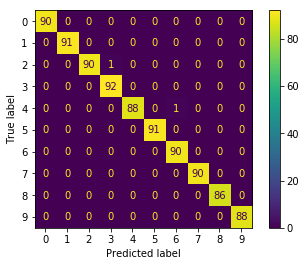

Classification test report for estimator ESNRegressor(beta=0.0005, bi_directional=False, bias=0.8, ext_bias=0,
             input_scaling=0.1, k_in=5, k_res=5, leakage=0.1, random_state=1,
             reservoir_activation='tanh', reservoir_size=1000, solver='ridge',
             spectral_radius=1.0, teacher_scaling=1.0, teacher_shift=0.0,
             wash_out=0):
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        88
           1       0.96      0.96      0.96        91
           2       0.84      0.80      0.82        86
           3       0.82      0.88      0.85        91
           4       0.93      0.97      0.95        92
           5       0.89      0.90      0.90        91
           6       0.93      0.96      0.94        91
           7       0.83      0.85      0.84        89
           8       0.84      0.84      0.84        88
           9       0.94      0.84      0.89        92

    accuracy                        

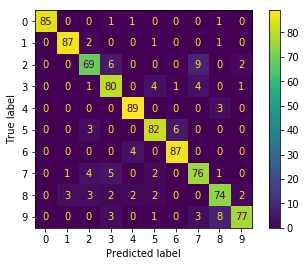

{'bi_directional': False, 'reservoir_size': 2000}
Classification training report for estimator ESNRegressor(beta=0.0005, bi_directional=False, bias=0.8, ext_bias=0,
             input_scaling=0.1, k_in=5, k_res=5, leakage=0.1, random_state=1,
             reservoir_activation='tanh', reservoir_size=2000, solver='ridge',
             spectral_radius=1.0, teacher_scaling=1.0, teacher_shift=0.0,
             wash_out=0):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        90
           1       1.00      1.00      1.00        91
           2       1.00      0.99      0.99        91
           3       0.99      1.00      0.99        92
           4       1.00      1.00      1.00        89
           5       1.00      1.00      1.00        91
           6       1.00      1.00      1.00        90
           7       1.00      1.00      1.00        90
           8       1.00      1.00      1.00        86
           9       1.00      1.00    

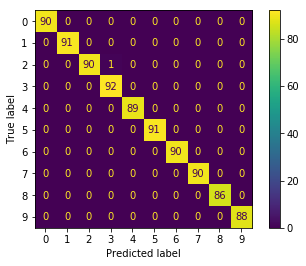

Classification test report for estimator ESNRegressor(beta=0.0005, bi_directional=False, bias=0.8, ext_bias=0,
             input_scaling=0.1, k_in=5, k_res=5, leakage=0.1, random_state=1,
             reservoir_activation='tanh', reservoir_size=2000, solver='ridge',
             spectral_radius=1.0, teacher_scaling=1.0, teacher_shift=0.0,
             wash_out=0):
              precision    recall  f1-score   support

           0       0.97      0.95      0.96        88
           1       0.96      0.95      0.95        91
           2       0.89      0.81      0.85        86
           3       0.79      0.85      0.81        91
           4       0.94      0.96      0.95        92
           5       0.89      0.90      0.90        91
           6       0.90      0.97      0.93        91
           7       0.80      0.78      0.79        89
           8       0.85      0.86      0.86        88
           9       0.92      0.86      0.89        92

    accuracy                        

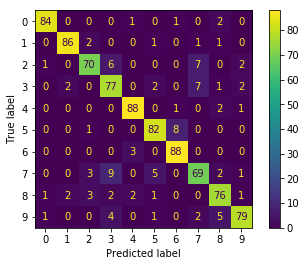

{'bi_directional': False, 'reservoir_size': 4000}
Classification training report for estimator ESNRegressor(beta=0.0005, bi_directional=False, bias=0.8, ext_bias=0,
             input_scaling=0.1, k_in=5, k_res=5, leakage=0.1, random_state=1,
             reservoir_activation='tanh', reservoir_size=4000, solver='ridge',
             spectral_radius=1.0, teacher_scaling=1.0, teacher_shift=0.0,
             wash_out=0):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        90
           1       1.00      1.00      1.00        91
           2       1.00      1.00      1.00        91
           3       1.00      1.00      1.00        92
           4       1.00      1.00      1.00        89
           5       1.00      1.00      1.00        91
           6       1.00      1.00      1.00        90
           7       1.00      1.00      1.00        90
           8       1.00      1.00      1.00        86
           9       1.00      1.00    

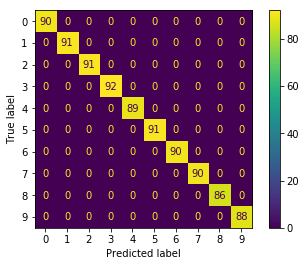

Classification test report for estimator ESNRegressor(beta=0.0005, bi_directional=False, bias=0.8, ext_bias=0,
             input_scaling=0.1, k_in=5, k_res=5, leakage=0.1, random_state=1,
             reservoir_activation='tanh', reservoir_size=4000, solver='ridge',
             spectral_radius=1.0, teacher_scaling=1.0, teacher_shift=0.0,
             wash_out=0):
              precision    recall  f1-score   support

           0       0.98      0.94      0.96        88
           1       0.98      0.93      0.96        91
           2       0.86      0.77      0.81        86
           3       0.79      0.88      0.83        91
           4       0.90      0.96      0.93        92
           5       0.91      0.89      0.90        91
           6       0.90      0.97      0.93        91
           7       0.76      0.79      0.77        89
           8       0.86      0.81      0.83        88
           9       0.88      0.85      0.86        92

    accuracy                        

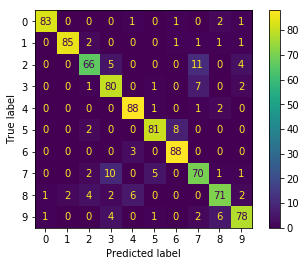

{'bi_directional': False, 'reservoir_size': 5000}
Classification training report for estimator ESNRegressor(beta=0.0005, bi_directional=False, bias=0.8, ext_bias=0,
             input_scaling=0.1, k_in=5, k_res=5, leakage=0.1, random_state=1,
             reservoir_activation='tanh', reservoir_size=5000, solver='ridge',
             spectral_radius=1.0, teacher_scaling=1.0, teacher_shift=0.0,
             wash_out=0):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        90
           1       1.00      1.00      1.00        91
           2       1.00      1.00      1.00        91
           3       1.00      1.00      1.00        92
           4       1.00      1.00      1.00        89
           5       1.00      1.00      1.00        91
           6       1.00      1.00      1.00        90
           7       1.00      1.00      1.00        90
           8       1.00      1.00      1.00        86
           9       1.00      1.00    

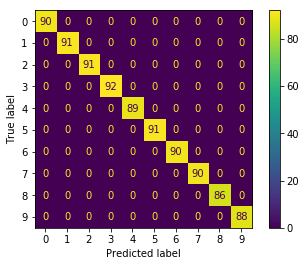

Classification test report for estimator ESNRegressor(beta=0.0005, bi_directional=False, bias=0.8, ext_bias=0,
             input_scaling=0.1, k_in=5, k_res=5, leakage=0.1, random_state=1,
             reservoir_activation='tanh', reservoir_size=5000, solver='ridge',
             spectral_radius=1.0, teacher_scaling=1.0, teacher_shift=0.0,
             wash_out=0):
              precision    recall  f1-score   support

           0       0.92      0.94      0.93        88
           1       0.98      0.95      0.96        91
           2       0.88      0.80      0.84        86
           3       0.78      0.86      0.82        91
           4       0.91      0.93      0.92        92
           5       0.90      0.93      0.92        91
           6       0.90      0.96      0.93        91
           7       0.80      0.76      0.78        89
           8       0.83      0.83      0.83        88
           9       0.90      0.83      0.86        92

    accuracy                        

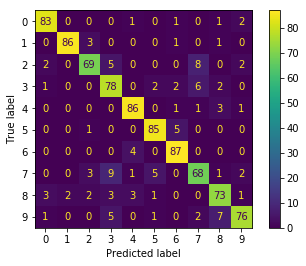

{'bi_directional': True, 'reservoir_size': 50}
Classification training report for estimator ESNRegressor(beta=0.0005, bi_directional=True, bias=0.8, ext_bias=0,
             input_scaling=0.1, k_in=5, k_res=5, leakage=0.1, random_state=1,
             reservoir_activation='tanh', reservoir_size=50, solver='ridge',
             spectral_radius=1.0, teacher_scaling=1.0, teacher_shift=0.0,
             wash_out=0):
              precision    recall  f1-score   support

           0       0.96      0.99      0.97        90
           1       0.90      0.97      0.93        91
           2       1.00      0.87      0.93        91
           3       0.92      0.92      0.92        92
           4       0.93      0.98      0.95        89
           5       0.96      0.97      0.96        91
           6       0.97      0.96      0.96        90
           7       0.87      0.97      0.92        90
           8       0.89      0.86      0.88        86
           9       0.94      0.83      0.88

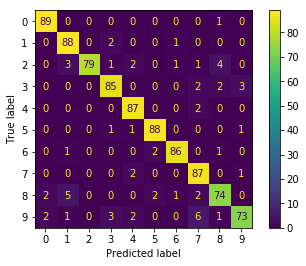

Classification test report for estimator ESNRegressor(beta=0.0005, bi_directional=True, bias=0.8, ext_bias=0,
             input_scaling=0.1, k_in=5, k_res=5, leakage=0.1, random_state=1,
             reservoir_activation='tanh', reservoir_size=50, solver='ridge',
             spectral_radius=1.0, teacher_scaling=1.0, teacher_shift=0.0,
             wash_out=0):
              precision    recall  f1-score   support

           0       0.95      0.94      0.95        88
           1       0.76      0.76      0.76        91
           2       0.93      0.79      0.86        86
           3       0.85      0.66      0.74        91
           4       0.80      0.97      0.88        92
           5       0.76      0.78      0.77        91
           6       0.96      0.97      0.96        91
           7       0.87      0.91      0.89        89
           8       0.88      0.72      0.79        88
           9       0.67      0.85      0.75        92

    accuracy                           

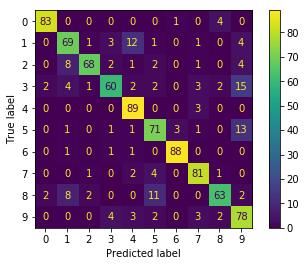

{'bi_directional': True, 'reservoir_size': 100}
Classification training report for estimator ESNRegressor(beta=0.0005, bi_directional=True, bias=0.8, ext_bias=0,
             input_scaling=0.1, k_in=5, k_res=5, leakage=0.1, random_state=1,
             reservoir_activation='tanh', reservoir_size=100, solver='ridge',
             spectral_radius=1.0, teacher_scaling=1.0, teacher_shift=0.0,
             wash_out=0):
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        90
           1       0.97      0.99      0.98        91
           2       0.98      0.97      0.97        91
           3       0.95      0.99      0.97        92
           4       1.00      1.00      1.00        89
           5       0.98      0.97      0.97        91
           6       0.99      0.98      0.98        90
           7       0.92      0.97      0.94        90
           8       0.96      0.93      0.95        86
           9       0.95      0.88      0.

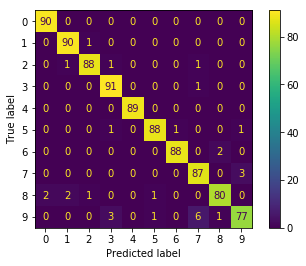

Classification test report for estimator ESNRegressor(beta=0.0005, bi_directional=True, bias=0.8, ext_bias=0,
             input_scaling=0.1, k_in=5, k_res=5, leakage=0.1, random_state=1,
             reservoir_activation='tanh', reservoir_size=100, solver='ridge',
             spectral_radius=1.0, teacher_scaling=1.0, teacher_shift=0.0,
             wash_out=0):
              precision    recall  f1-score   support

           0       0.97      0.95      0.96        88
           1       0.91      0.86      0.88        91
           2       0.95      0.94      0.95        86
           3       0.84      0.77      0.80        91
           4       0.94      0.97      0.95        92
           5       0.91      0.82      0.87        91
           6       0.95      0.99      0.97        91
           7       0.87      0.94      0.90        89
           8       0.92      0.90      0.91        88
           9       0.78      0.87      0.82        92

    accuracy                          

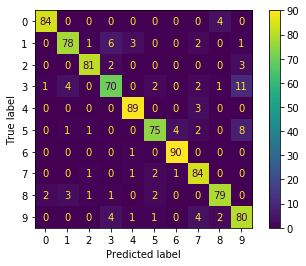

{'bi_directional': True, 'reservoir_size': 200}
Classification training report for estimator ESNRegressor(beta=0.0005, bi_directional=True, bias=0.8, ext_bias=0,
             input_scaling=0.1, k_in=5, k_res=5, leakage=0.1, random_state=1,
             reservoir_activation='tanh', reservoir_size=200, solver='ridge',
             spectral_radius=1.0, teacher_scaling=1.0, teacher_shift=0.0,
             wash_out=0):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        90
           1       0.99      1.00      0.99        91
           2       1.00      1.00      1.00        91
           3       0.99      1.00      0.99        92
           4       0.99      1.00      0.99        89
           5       1.00      0.98      0.99        91
           6       1.00      1.00      1.00        90
           7       0.98      1.00      0.99        90
           8       1.00      0.99      0.99        86
           9       1.00      0.98      0.

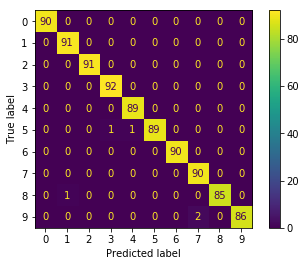

Classification test report for estimator ESNRegressor(beta=0.0005, bi_directional=True, bias=0.8, ext_bias=0,
             input_scaling=0.1, k_in=5, k_res=5, leakage=0.1, random_state=1,
             reservoir_activation='tanh', reservoir_size=200, solver='ridge',
             spectral_radius=1.0, teacher_scaling=1.0, teacher_shift=0.0,
             wash_out=0):
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        88
           1       0.92      0.96      0.94        91
           2       0.98      0.95      0.96        86
           3       0.95      0.86      0.90        91
           4       0.98      0.97      0.97        92
           5       0.91      0.87      0.89        91
           6       0.97      0.99      0.98        91
           7       0.89      0.99      0.94        89
           8       0.93      0.91      0.92        88
           9       0.85      0.89      0.87        92

    accuracy                          

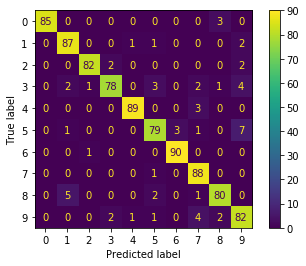

{'bi_directional': True, 'reservoir_size': 400}
Classification training report for estimator ESNRegressor(beta=0.0005, bi_directional=True, bias=0.8, ext_bias=0,
             input_scaling=0.1, k_in=5, k_res=5, leakage=0.1, random_state=1,
             reservoir_activation='tanh', reservoir_size=400, solver='ridge',
             spectral_radius=1.0, teacher_scaling=1.0, teacher_shift=0.0,
             wash_out=0):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        90
           1       1.00      1.00      1.00        91
           2       1.00      1.00      1.00        91
           3       1.00      1.00      1.00        92
           4       1.00      1.00      1.00        89
           5       1.00      1.00      1.00        91
           6       1.00      1.00      1.00        90
           7       1.00      1.00      1.00        90
           8       1.00      1.00      1.00        86
           9       1.00      1.00      1.

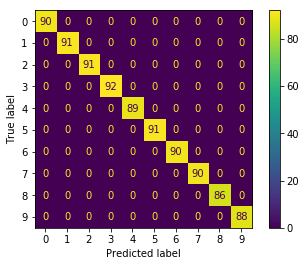

Classification test report for estimator ESNRegressor(beta=0.0005, bi_directional=True, bias=0.8, ext_bias=0,
             input_scaling=0.1, k_in=5, k_res=5, leakage=0.1, random_state=1,
             reservoir_activation='tanh', reservoir_size=400, solver='ridge',
             spectral_radius=1.0, teacher_scaling=1.0, teacher_shift=0.0,
             wash_out=0):
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        88
           1       0.96      0.95      0.95        91
           2       0.99      0.93      0.96        86
           3       0.99      0.86      0.92        91
           4       0.99      0.97      0.98        92
           5       0.92      0.96      0.94        91
           6       0.99      1.00      0.99        91
           7       0.94      0.99      0.96        89
           8       0.91      0.94      0.93        88
           9       0.84      0.91      0.87        92

    accuracy                          

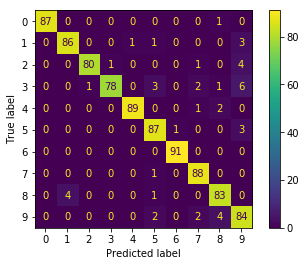

{'bi_directional': True, 'reservoir_size': 500}
Classification training report for estimator ESNRegressor(beta=0.0005, bi_directional=True, bias=0.8, ext_bias=0,
             input_scaling=0.1, k_in=5, k_res=5, leakage=0.1, random_state=1,
             reservoir_activation='tanh', reservoir_size=500, solver='ridge',
             spectral_radius=1.0, teacher_scaling=1.0, teacher_shift=0.0,
             wash_out=0):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        90
           1       1.00      1.00      1.00        91
           2       1.00      1.00      1.00        91
           3       1.00      1.00      1.00        92
           4       1.00      1.00      1.00        89
           5       1.00      1.00      1.00        91
           6       1.00      1.00      1.00        90
           7       1.00      1.00      1.00        90
           8       1.00      1.00      1.00        86
           9       1.00      1.00      1.

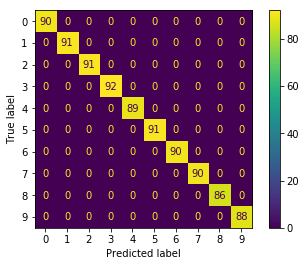

Classification test report for estimator ESNRegressor(beta=0.0005, bi_directional=True, bias=0.8, ext_bias=0,
             input_scaling=0.1, k_in=5, k_res=5, leakage=0.1, random_state=1,
             reservoir_activation='tanh', reservoir_size=500, solver='ridge',
             spectral_radius=1.0, teacher_scaling=1.0, teacher_shift=0.0,
             wash_out=0):
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        88
           1       0.97      0.93      0.95        91
           2       0.96      0.93      0.95        86
           3       0.98      0.87      0.92        91
           4       0.98      0.97      0.97        92
           5       0.93      0.96      0.94        91
           6       0.97      1.00      0.98        91
           7       0.94      0.99      0.96        89
           8       0.89      0.95      0.92        88
           9       0.88      0.90      0.89        92

    accuracy                          

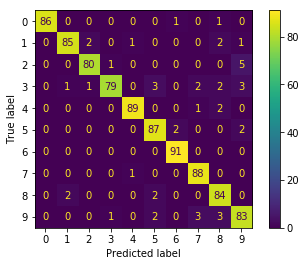

{'bi_directional': True, 'reservoir_size': 800}
Classification training report for estimator ESNRegressor(beta=0.0005, bi_directional=True, bias=0.8, ext_bias=0,
             input_scaling=0.1, k_in=5, k_res=5, leakage=0.1, random_state=1,
             reservoir_activation='tanh', reservoir_size=800, solver='ridge',
             spectral_radius=1.0, teacher_scaling=1.0, teacher_shift=0.0,
             wash_out=0):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        90
           1       1.00      1.00      1.00        91
           2       1.00      1.00      1.00        91
           3       1.00      1.00      1.00        92
           4       1.00      1.00      1.00        89
           5       1.00      1.00      1.00        91
           6       1.00      1.00      1.00        90
           7       1.00      1.00      1.00        90
           8       1.00      1.00      1.00        86
           9       1.00      1.00      1.

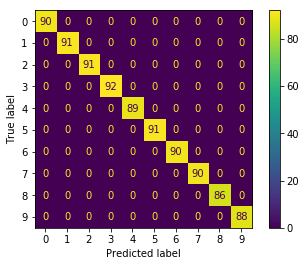

Classification test report for estimator ESNRegressor(beta=0.0005, bi_directional=True, bias=0.8, ext_bias=0,
             input_scaling=0.1, k_in=5, k_res=5, leakage=0.1, random_state=1,
             reservoir_activation='tanh', reservoir_size=800, solver='ridge',
             spectral_radius=1.0, teacher_scaling=1.0, teacher_shift=0.0,
             wash_out=0):
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        88
           1       0.97      0.98      0.97        91
           2       0.96      0.95      0.96        86
           3       0.96      0.89      0.93        91
           4       1.00      0.97      0.98        92
           5       0.92      0.93      0.93        91
           6       0.97      1.00      0.98        91
           7       0.95      0.98      0.96        89
           8       0.92      0.97      0.94        88
           9       0.90      0.91      0.91        92

    accuracy                          

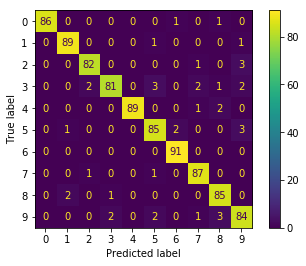

{'bi_directional': True, 'reservoir_size': 1000}
Classification training report for estimator ESNRegressor(beta=0.0005, bi_directional=True, bias=0.8, ext_bias=0,
             input_scaling=0.1, k_in=5, k_res=5, leakage=0.1, random_state=1,
             reservoir_activation='tanh', reservoir_size=1000, solver='ridge',
             spectral_radius=1.0, teacher_scaling=1.0, teacher_shift=0.0,
             wash_out=0):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        90
           1       1.00      1.00      1.00        91
           2       1.00      1.00      1.00        91
           3       1.00      1.00      1.00        92
           4       1.00      1.00      1.00        89
           5       1.00      1.00      1.00        91
           6       1.00      1.00      1.00        90
           7       1.00      1.00      1.00        90
           8       1.00      1.00      1.00        86
           9       1.00      1.00      

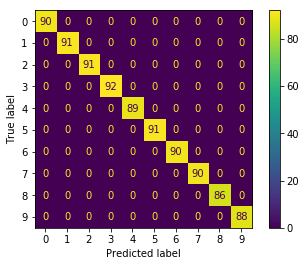

Classification test report for estimator ESNRegressor(beta=0.0005, bi_directional=True, bias=0.8, ext_bias=0,
             input_scaling=0.1, k_in=5, k_res=5, leakage=0.1, random_state=1,
             reservoir_activation='tanh', reservoir_size=1000, solver='ridge',
             spectral_radius=1.0, teacher_scaling=1.0, teacher_shift=0.0,
             wash_out=0):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        88
           1       0.95      0.98      0.96        91
           2       1.00      0.94      0.97        86
           3       0.99      0.91      0.95        91
           4       1.00      0.97      0.98        92
           5       0.94      0.96      0.95        91
           6       0.98      1.00      0.99        91
           7       0.95      1.00      0.97        89
           8       0.96      0.97      0.96        88
           9       0.91      0.93      0.92        92

    accuracy                         

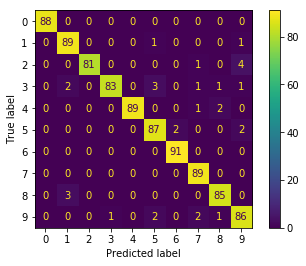

{'bi_directional': True, 'reservoir_size': 2000}
Classification training report for estimator ESNRegressor(beta=0.0005, bi_directional=True, bias=0.8, ext_bias=0,
             input_scaling=0.1, k_in=5, k_res=5, leakage=0.1, random_state=1,
             reservoir_activation='tanh', reservoir_size=2000, solver='ridge',
             spectral_radius=1.0, teacher_scaling=1.0, teacher_shift=0.0,
             wash_out=0):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        90
           1       1.00      1.00      1.00        91
           2       1.00      1.00      1.00        91
           3       1.00      1.00      1.00        92
           4       1.00      1.00      1.00        89
           5       1.00      1.00      1.00        91
           6       1.00      1.00      1.00        90
           7       1.00      1.00      1.00        90
           8       1.00      1.00      1.00        86
           9       1.00      1.00      

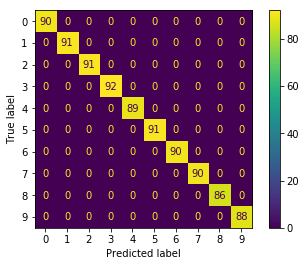

Classification test report for estimator ESNRegressor(beta=0.0005, bi_directional=True, bias=0.8, ext_bias=0,
             input_scaling=0.1, k_in=5, k_res=5, leakage=0.1, random_state=1,
             reservoir_activation='tanh', reservoir_size=2000, solver='ridge',
             spectral_radius=1.0, teacher_scaling=1.0, teacher_shift=0.0,
             wash_out=0):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        88
           1       0.96      0.98      0.97        91
           2       0.98      0.94      0.96        86
           3       0.96      0.90      0.93        91
           4       1.00      0.96      0.98        92
           5       0.94      0.96      0.95        91
           6       0.99      1.00      0.99        91
           7       0.94      1.00      0.97        89
           8       0.96      0.99      0.97        88
           9       0.92      0.91      0.92        92

    accuracy                         

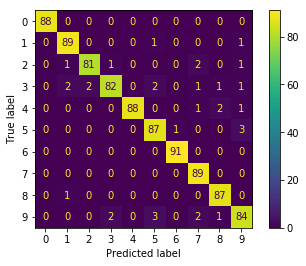

{'bi_directional': True, 'reservoir_size': 4000}
Classification training report for estimator ESNRegressor(beta=0.0005, bi_directional=True, bias=0.8, ext_bias=0,
             input_scaling=0.1, k_in=5, k_res=5, leakage=0.1, random_state=1,
             reservoir_activation='tanh', reservoir_size=4000, solver='ridge',
             spectral_radius=1.0, teacher_scaling=1.0, teacher_shift=0.0,
             wash_out=0):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        90
           1       1.00      1.00      1.00        91
           2       1.00      1.00      1.00        91
           3       1.00      1.00      1.00        92
           4       1.00      1.00      1.00        89
           5       1.00      1.00      1.00        91
           6       1.00      1.00      1.00        90
           7       1.00      1.00      1.00        90
           8       1.00      1.00      1.00        86
           9       1.00      1.00      

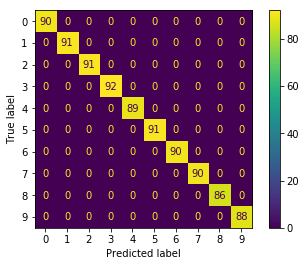

Classification test report for estimator ESNRegressor(beta=0.0005, bi_directional=True, bias=0.8, ext_bias=0,
             input_scaling=0.1, k_in=5, k_res=5, leakage=0.1, random_state=1,
             reservoir_activation='tanh', reservoir_size=4000, solver='ridge',
             spectral_radius=1.0, teacher_scaling=1.0, teacher_shift=0.0,
             wash_out=0):
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        88
           1       0.97      0.97      0.97        91
           2       0.96      0.93      0.95        86
           3       0.98      0.89      0.93        91
           4       0.99      0.96      0.97        92
           5       0.95      0.97      0.96        91
           6       0.99      1.00      0.99        91
           7       0.93      1.00      0.96        89
           8       0.97      0.97      0.97        88
           9       0.87      0.91      0.89        92

    accuracy                         

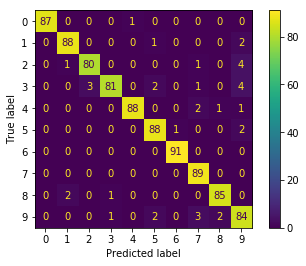

{'bi_directional': True, 'reservoir_size': 5000}
Classification training report for estimator ESNRegressor(beta=0.0005, bi_directional=True, bias=0.8, ext_bias=0,
             input_scaling=0.1, k_in=5, k_res=5, leakage=0.1, random_state=1,
             reservoir_activation='tanh', reservoir_size=5000, solver='ridge',
             spectral_radius=1.0, teacher_scaling=1.0, teacher_shift=0.0,
             wash_out=0):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        90
           1       1.00      1.00      1.00        91
           2       1.00      1.00      1.00        91
           3       1.00      1.00      1.00        92
           4       1.00      1.00      1.00        89
           5       1.00      1.00      1.00        91
           6       1.00      1.00      1.00        90
           7       1.00      1.00      1.00        90
           8       1.00      1.00      1.00        86
           9       1.00      1.00      

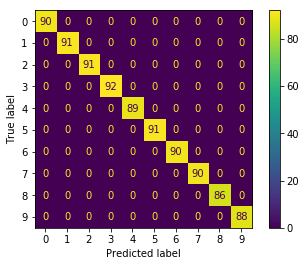

Classification test report for estimator ESNRegressor(beta=0.0005, bi_directional=True, bias=0.8, ext_bias=0,
             input_scaling=0.1, k_in=5, k_res=5, leakage=0.1, random_state=1,
             reservoir_activation='tanh', reservoir_size=5000, solver='ridge',
             spectral_radius=1.0, teacher_scaling=1.0, teacher_shift=0.0,
             wash_out=0):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        88
           1       0.98      0.98      0.98        91
           2       0.95      0.94      0.95        86
           3       0.96      0.89      0.93        91
           4       0.99      0.96      0.97        92
           5       0.95      0.96      0.95        91
           6       0.99      1.00      0.99        91
           7       0.97      1.00      0.98        89
           8       0.94      0.95      0.95        88
           9       0.88      0.92      0.90        92

    accuracy                         

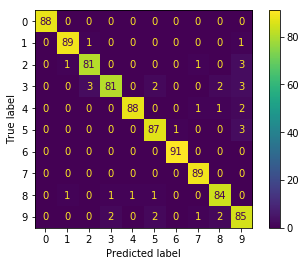

In [11]:
for params in ParameterGrid(grid):
    print(params)
    reg = clone(base_reg)
    reg.set_params(**params)
    for X, y in zip(X_train, y_train):
        y = np.repeat(np.atleast_2d(y), repeats=8, axis=0)
        reg.partial_fit(X=X, y=y, update_output_weights=False)
    reg.finalize()
    Y_true_train = []
    Y_pred_train = []
    for X, y in zip(X_train, y_train):
        y_pred = reg.predict(X=X, keep_reservoir_state=False)
        Y_true_train.append(np.argmax(y))
        Y_pred_train.append(np.argmax(y_pred.sum(axis=0)))
    
    Y_true_test = []
    Y_pred_test = []
    for X, y in zip(X_test, y_test):
        y_pred = reg.predict(X=X, keep_reservoir_state=False)
        Y_true_test.append(np.argmax(y))
        Y_pred_test.append(np.argmax(y_pred.sum(axis=0)))
    cm = confusion_matrix(Y_true_train, Y_pred_train)
    cm_display = ConfusionMatrixDisplay(cm, display_labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).plot()
    print("Classification training report for estimator %s:\n%s\n"
      % (reg, classification_report(Y_true_train, Y_pred_train)))
    plt.show()
    
    cm = confusion_matrix(Y_true_test, Y_pred_test)
    cm_display = ConfusionMatrixDisplay(cm, display_labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).plot()
    print("Classification test report for estimator %s:\n%s\n"
      % (reg, classification_report(Y_true_test, Y_pred_test)))
    plt.show()